In [1]:
import autograd as ad
import autograd.variable as av
import numpy as np

In [11]:
def loss_function(params):
    var = av.Variable(params)
    x, y = var[0], var[1]
    
    b1 = ad.exp(-0.1*((x**2)+(y**2)))
    b2 = ad.cos(0.5*(x+y))
    b3 = b1*b2+0.1*(x+y)+ad.exp(0.1*(3-(x+y)))
    
    b3.compute_gradients()
    return (b3.data, b3.gradient)

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer) 

In [4]:
from autograd.optimize import GD, Adam

In [47]:
def plot_nice_surface_and_gradients(f, lim_inf, lim_sup, iterations=50, startingPoint=[0.1,-0.1], 
                                   title='vector function plus gradient descent algorithm',
                                   solver='adam',
                                   lr=0.1):
    x=np.linspace(lim_inf,lim_sup,100)
    y=np.linspace(lim_inf,lim_sup,100)

    X,Y=np.meshgrid(x,y)
        
    def data_function(a, b):
        data, grad= f([a, b])
        return(data)
    
    vf=np.vectorize(data_function)

    Z=vf(X,Y)

    fig = plt.figure(figsize=(12,10))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                          cmap=cm.RdBu,linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

    fig.colorbar(surf, shrink=0.5, aspect=5)

    if solver=='adam':
        optimizer = Adam(f, startingPoint, lr=lr, max_iter=iterations)
    elif solver=='gd':
        optimizer = GD(f, startingPoint, lr=lr, max_iter=iterations)
    else:
        raise ValueError('Encountered unexpected solver flag.')
    
    soln, steps = optimizer.solve(return_steps=True)
    for i in range(1, len(steps)):
        x, x_n = steps[i-1][0], steps[i][0]
        y, y_n = steps[i-1][1], steps[i][1]
        z, z_n = data_function(x, y), data_function(x_n, y_n)
        
        a = Arrow3D([x, x_n], [y, y_n],
                   [z, z_n], mutation_scale=20,
                   lw=1, arrowstyle="-|>", color="r")
        ax.add_artist(a)
        
    ax.add_artist(a)
    plt.draw()
    plt.show()

## Simple, well conditioned problem

$$f(x,y)=\cos(0.5\cdot(x+y)) \cdot e^{(-0.1\cdot(x^2 + y^2))}+ 0.1\cdot(x+y) + e^{(0.1 \cdot(3-(x+y))}$$

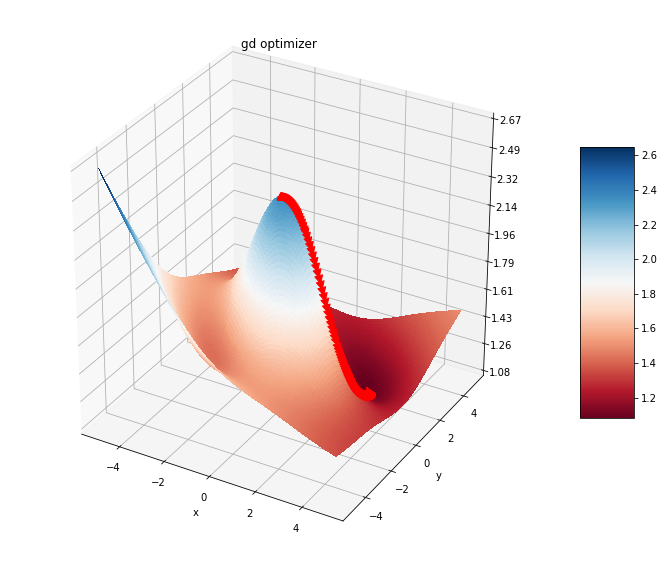

In [24]:
plot_nice_surface_and_gradients(loss_function, -5, 5, 
                                title='gd optimizer', 
                                solver='gd',
                                lr=0.1,
                                iterations=1000)

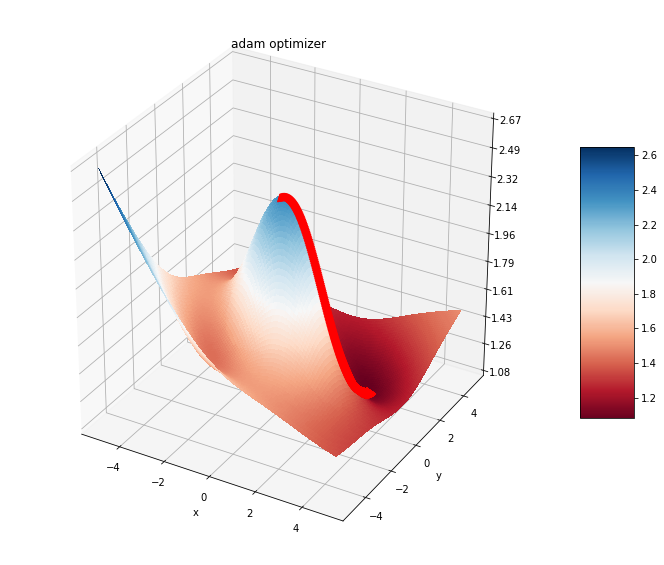

In [22]:
plot_nice_surface_and_gradients(loss_function, -5, 5, 
                                title='adam optimizer', 
                                solver='adam', 
                                lr=0.01,
                                iterations=1000)

## Different starting points

### Non-convergence of GD!

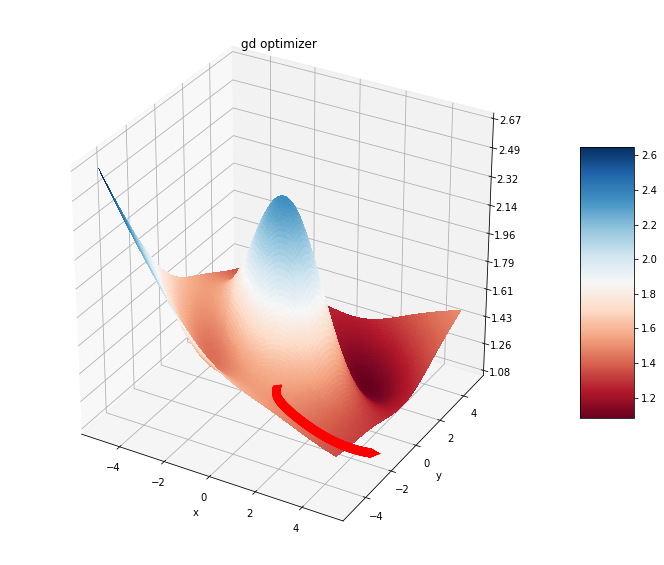

In [38]:
plot_nice_surface_and_gradients(loss_function, -5, 5, 
                                title='gd optimizer', 
                                solver='gd',
                                startingPoint=[2,-4],
                                lr=0.1,
                                iterations=1000)

### Adam converges!

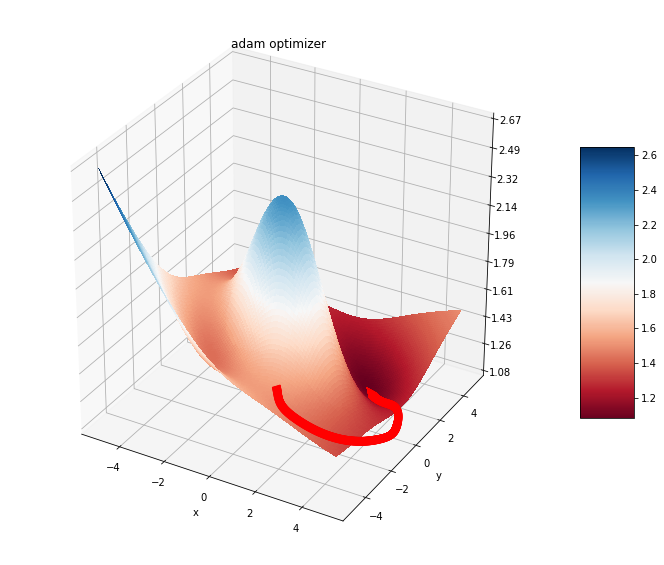

In [39]:
plot_nice_surface_and_gradients(loss_function, -5, 5, 
                                title='adam optimizer', 
                                solver='adam', 
                                startingPoint=[2,-4],
                                lr=0.01,
                                iterations=1000)

### 10x Iterations for GD and still does not converge!

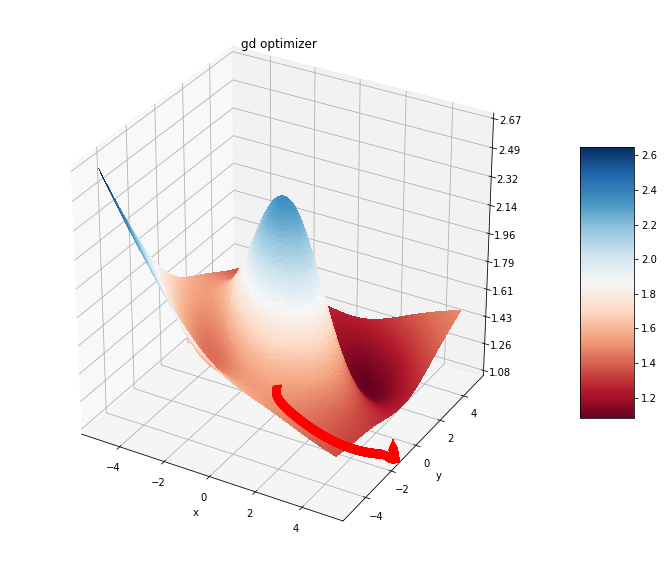

In [35]:
plot_nice_surface_and_gradients(loss_function, -5, 5, 
                                title='gd optimizer', 
                                solver='gd',
                                startingPoint=[2,-4],
                                lr=0.1,
                                iterations=10000)

## Beale Function
- optimum = **(3, 0.5)**

- inspired by https://arxiv.org/pdf/1609.04747.pdf and https://en.wikipedia.org/wiki/Test_functions_for_optimization

In [40]:
def beale_function(params):
    var = av.Variable(params)
    x, y = var[0], var[1]
    
    b1 = (1.5-x+x*y)**2
    b2 = (2.25-x+x*(y**2))**2
    b3 = (2.625-x+x*(y**3))**2
    
    b3.compute_gradients()
    return (b3.data, b3.gradient)

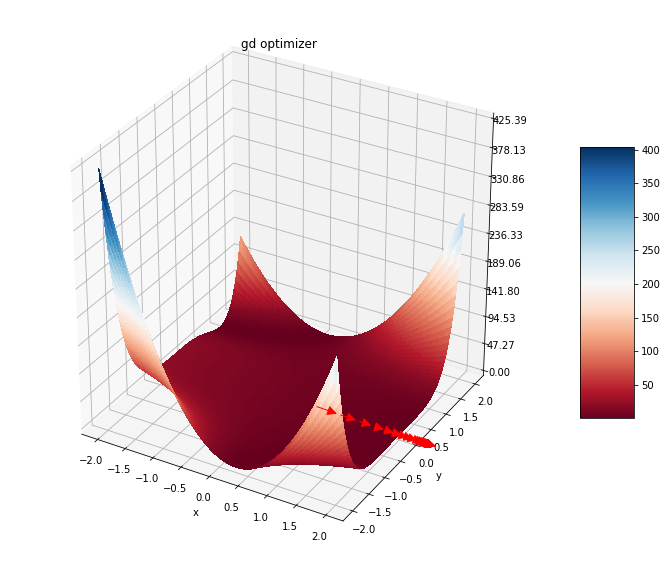

In [56]:
plot_nice_surface_and_gradients(beale_function, -2, 2,
                                startingPoint=[0,0],
                                title='gd optimizer', 
                                solver='gd', 
                                lr=0.1,
                                iterations=1000)

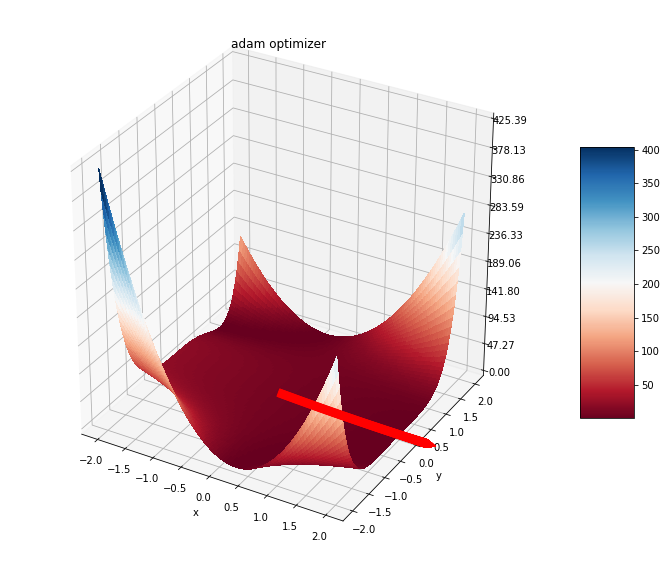

In [57]:
plot_nice_surface_and_gradients(beale_function, -2, 2,
                                startingPoint=[0,0],
                                title='adam optimizer', 
                                solver='adam', 
                                lr=0.01,
                                iterations=1000)

### Enough with the pictures, show me some tables

In [60]:
start_samps = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=100)

In [62]:
optimal_sol = [3, 0.5]

In [64]:
gd_sols, adam_sols = [], []

In [65]:
for s in start_samps:
    gd = GD(beale_function, s, lr=0.1, max_iter=1000)
    gd_sols.append(gd.solve())
    adam = Adam(beale_function, s, lr=0.01, max_iter=1000)
    adam_sols.append(adam.solve())

/Users/dylanrandle/Documents/Harvard/cs207/cs207-FinalProject/autograd/blocks/operations.py:104: RuntimeWarning: overflow encountered in float_power
  new_data = np.float_power(input_var.data, power_exponent)
/Users/dylanrandle/Documents/Harvard/cs207/cs207-FinalProject/autograd/blocks/operations.py:24: RuntimeWarning: invalid value encountered in add
  new_data = np.add(args[0].data, args[1].data)
/Users/dylanrandle/Documents/Harvard/cs207/cs207-FinalProject/autograd/optimize.py:48: RuntimeWarning: invalid value encountered in subtract
  if abs(prev_loss - new_loss) < self.tol:
/Users/dylanrandle/Documents/Harvard/cs207/cs207-FinalProject/autograd/blocks/operations.py:58: RuntimeWarning: overflow encountered in multiply
  new_data = np.multiply(args[0].data, args[1].data)
/Users/dylanrandle/Documents/Harvard/cs207/cs207-FinalProject/autograd/blocks/operations.py:108: RuntimeWarning: overflow encountered in square
  new_grad = power_exponent*input_var.data**(power_exponent-1)


In [67]:
gd_converged, adam_converged = 0, 0
for gsol, asol in zip(gd_sols, adam_sols):
    if all(gsol == optimal_sol):
        gd_converged += 1
    if all(asol == optimal_sol):
        adam_converged += 1

In [70]:
gd_sols

[array([nan, nan]),
 array([nan, nan]),
 array([2.62613919, 0.07570206]),
 array([nan, nan]),
 array([2.62614083, 0.07573831]),
 array([2.62609526, 0.07471714]),
 array([nan, nan]),
 array([2.62543387, 0.05488194]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([2.62502025, 0.01979552]),
 array([2.62500029, 0.00537936]),
 array([nan, nan]),
 array([2.6261376 , 0.07566682]),
 array([2.62653778, 0.08365966]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([ 2.62499884, -0.00735561]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([nan, nan]),
 array([2.62605763, 0.07385166]),
 array([2.62516345, 0.03964396]),
 array([2.62603876, 0.07340981]),
 array([2.62617358, 0.07645598]),
 array([2.62534639, 0.05091442]),
 array([2.6261737 , 0.07645859]),
 array([2.62579843, 0.06724822]),
 array([ 1.97255153, -0.69157511]),
 array([nan, nan]),
 array([nan, nan]),
 array([2.62559732, 0.06105094]),
 array([ 2.60537805, -0.

In [68]:
print(gd_converged, adam_converged)

0 0
